### Import Packages

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

print("Packages Imported")

Packages Imported


### Inputs

In [2]:
cwd = os.getcwd()
in_subpath = "output_final\\1 - Initial Testing"
in_file = "sir_250000_beta_random_gamma_fixed_2"
in_path = os.path.join(cwd, in_subpath, in_file)

print("Input Path Set")

Input Path Set


### Load Data

In [8]:
# LOAD DATA
print("\nLoading Data")
data_raw = pd.read_csv('output_sir_monte_carlo_test.csv', delimiter=',', header=None)
data_eval = data_raw.to_numpy()
print("Data Loaded")

indx_p_start = np.where(data_eval[0] == 666)[0][0]
indx_i_start = np.where(data_eval[0] == 777)[0][0]
indx_end = np.where(data_eval[0] == 999)[0][0]


Loading Data
Data Loaded


### Process Data

In [9]:
n_days = 120

param_start = indx_p_start + 1
param_end = indx_i_start - indx_p_start

i_start = param_end + 1
i_end = i_start + n_days

y_data = data_eval[:, param_start:param_end]
x_raw = data_eval[:, i_start:i_end]

x_total = data_eval[:, i_start:i_start + 365]

n = len(x_total[0])
N = 4500000

# NORMALISE DATA (MIN/MAX)
if False:
    scaler = MinMaxScaler(feature_range=(0, 1))
    x_data = scaler.fit_transform(x_raw.reshape(n_days, 1)).T
else:
    x_data = x_raw / N

print("\nTesting Data:")
print("Sample: {0}".format(x_data.shape))


Testing Data:
Sample: (1, 120)


### Run Model

In [10]:
model1 = tf.keras.models.load_model(in_path)
model1.summary()

predictions_data = model1.predict(x_data) # make predictions on test set to compare with actual

print("\nSample Length # \t Beta - Actual \t Beta - NN")
print("{0} \t\t\t {1:.8f} \t {2:.8f}".format(n_days, y_data[0, 0], predictions_data[0, 0]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                7744      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 20,289
Trainable params: 20,289
Non-trainable params: 0
_________________________________________________________________

Sample Length # 	 Beta - Actual 	 Beta - NN
120 			 0.18229377 	 0.18230757


### Simulate ODE

In [11]:
I0 = 1
S0 = N - I0
R0 = 0

S = []
I = []
R = []

S.append(S0)
I.append(I0)
R.append(R0)

beta_real = y_data[0, 0]
gamma = y_data[0, 1]

beta_pred = float(predictions_data[0, 0])

for i in range(0, n - 1): # solve ODE using NN beta estimate
    dS = - (beta_pred * S[i] * I[i] / N)
    dI = (beta_pred * S[i] * I[i] / N) - (gamma * I[i])
    dR = (gamma * I[i])

    Snew = S[i] + dS
    Inew = I[i] + dI
    Rnew = R[i] + dR

    S.append(Snew)
    I.append(Inew)
    R.append(Rnew)

# CALCULATE MSE
x_smple = x_total.reshape(n, )
mse = sum(np.abs(I - x_smple)**2) / len(I)
print("\nMSE: {0}".format(mse))



MSE: 27475.053052349096


### Plot Results

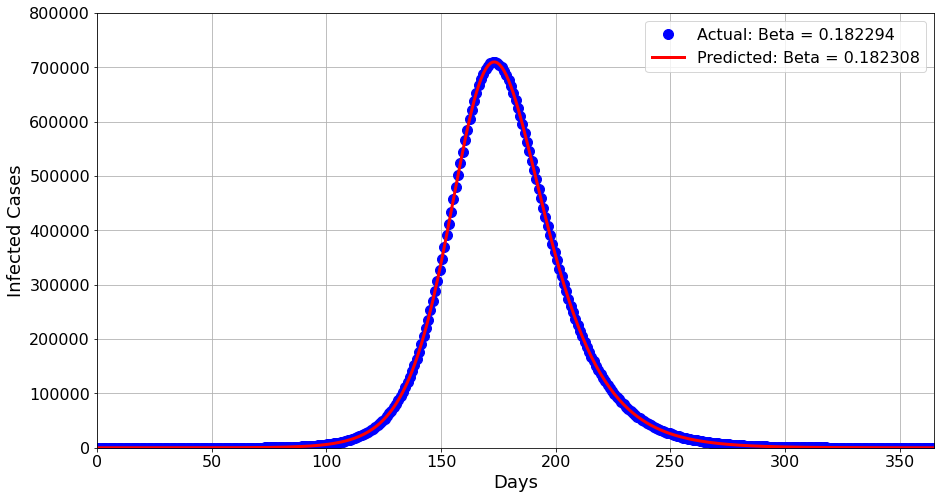

In [34]:
t_required = np.linspace(0, n, n)

plt.figure(figsize=(15,8))
plt.plot(t_required, x_smple, "ob", ms=10, label="Actual: Beta = {0:.6f}".format(beta_real))
plt.plot(t_required, I, "-r", linewidth=3, label="Predicted: Beta = {0:.6f}".format(beta_pred))
plt.xlabel("Days", fontsize=18)
plt.ylabel("Infected Cases", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 365)
plt.ylim(0, 800000)
plt.legend(loc='upper right', fontsize=16)
plt.grid()
plt.show()